# Chest X-Ray Images (Pneumonia)
- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


## File download using kaggle api

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyunho95","key":"43058ac4a07bf95d7ffd9c4cf49b5757"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         91           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        191           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        332           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2386            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      18388            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4956           False  
connectx

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:19<00:00, 177MB/s]
100% 2.29G/2.29G [00:19<00:00, 126MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/tra

In [1]:
# image loader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
image_train_generator = ImageDataGenerator(
    rotation_range = 20,
    brightness_range=(0.8, 1.2),
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range = 0.2,
    rescale = 1./255,
)

In [36]:
image_val_generator = ImageDataGenerator(rescale = 1./255,)

In [37]:
train_flow = image_train_generator.flow_from_directory(
    './chest_xray/chest_xray/train',
    # color_mode='grayscale',
    batch_size=32,
    seed = 1132,
    target_size=(128,128)
)

Found 5216 images belonging to 2 classes.


In [38]:
val_flow = image_val_generator.flow_from_directory(
    './chest_xray/chest_xray/val',
    # color_mode='grayscale',
    seed = 1132,
    target_size=(128,128)
)

Found 16 images belonging to 2 classes.


In [39]:
def make_model():
    model = keras.models.Sequential([
        layers.Input(shape=(128,128,3), name='input_layer'),
        layers.GaussianNoise(0.2, name='gaussian_blur'),
        layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
        layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu',),
        layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2)),
        layers.Conv2D(128, kernel_size=(7,7), padding='same', activation='relu', name='last_conv_layer'),
        layers.MaxPool2D(pool_size=(2,2), name= 'max_pooling_last'),
        layers.BatchNormalization(),
        layers.Flatten(name='flatten'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='relu', name = ''),
        layers.Dense(15, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ])
    return model

In [86]:
idx2class = { idx:cls for cls, idx in train_flow.class_indices.items()}

In [41]:
train_flow.labels.sum()

3875

In [42]:
with tf.device('/device:GPU:0'):
  model = make_model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor = 'val_accuracy')
  checkpoint = keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_accuracy', save_best_only=True)
  history = model.fit(train_flow, epochs=100, callbacks=[early_stopping, checkpoint], validation_data=val_flow)

Epoch 1/100
163/163 [==============================] - 78s 475ms/step - loss: 0.6200 - accuracy: 0.7629 - val_loss: 0.8646 - val_accuracy: 0.5625
Epoch 2/100
163/163 [==============================] - 77s 473ms/step - loss: 0.4012 - accuracy: 0.8181 - val_loss: 1.0299 - val_accuracy: 0.5625
Epoch 3/100
163/163 [==============================] - 77s 472ms/step - loss: 0.3749 - accuracy: 0.8377 - val_loss: 1.3112 - val_accuracy: 0.5625
Epoch 4/100
163/163 [==============================] - 77s 469ms/step - loss: 0.3742 - accuracy: 0.8229 - val_loss: 0.8521 - val_accuracy: 0.5625
Epoch 5/100
163/163 [==============================] - 77s 470ms/step - loss: 0.3740 - accuracy: 0.8280 - val_loss: 1.9555 - val_accuracy: 0.5000
Epoch 6/100
163/163 [==============================] - 76s 468ms/step - loss: 0.3402 - accuracy: 0.8496 - val_loss: 0.9248 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 76s 468ms/step - loss: 0.3384 - accuracy: 0.8483 - val_loss: 1.6584 -

In [46]:
best_model = keras.models.load_model('./best_model.h5')

In [9]:
from glob import glob
import os
import numpy as np

def load_image(path, target_size):
  X = []
  y = []
  NORMAL = glob(path+'NORMAL/*.jpeg')
  PNEUMONIA = glob(path+'PNEUMONIA/*.jpeg')
  for path_i in NORMAL:
    image = keras.preprocessing.image.load_img(path_i, target_size=target_size)
    image = keras.preprocessing.image.img_to_array(image)
    image = image/255.
    X.append(image)
    y.append(0)
  for path_i in PNEUMONIA:
    image = keras.preprocessing.image.load_img(path_i, target_size=target_size)
    image = keras.preprocessing.image.img_to_array(image)
    image = image/ 255.
    X.append(image)
    y.append(1)
  return np.asarray(X), np.asarray(y)

In [11]:
path = './chest_xray/test/'
X_test, y_test = load_image(path, target_size=(128, 128))

In [12]:
X_test.shape

(624, 128, 128, 3)

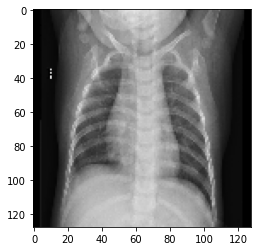

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_test[0], cmap='gray')

In [47]:
y_pred = best_model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)

print(f'accuracy = {accuracy}\nprecision = {precision}\nrecall={recall}')

accuracy = 0.7548076923076923
precision = 0.7453416149068323
recall=0.9230769230769231


390

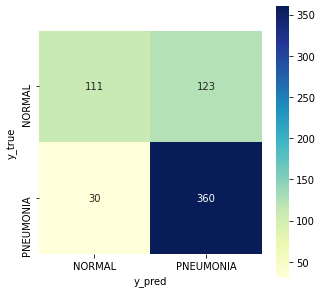

In [73]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['NORMAL', 'PNEUMONIA'], index=['NORMAL', 'PNEUMONIA']), annot=True, fmt='d', square=True,cmap='YlGnBu')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [74]:
def make_gradcam_heatmap(img_array, model):
  last_conv_layer = model.layers[9]
  last_conv_layer_model = keras.Model(model.input, last_conv_layer.output)
  
  classifier_layers = model.layers[-5:]
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for classifier_layer in classifier_layers:
    x = classifier_layer(x)
  classifier_model = keras.Model(classifier_input, x)

  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  heatmap = np.mean(last_conv_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

In [75]:
def get_image(img_path, size):
  img = keras.preprocessing.image.load_img(img_path, target_size=size)
  array = keras.preprocessing.image.img_to_array(img)
  array = array/ 255.
  array = np.expand_dims(array, axis=0)
  return array

In [76]:
image_path_ls = glob('./chest_xray/train/*/*.jpeg')

In [77]:
random_path = np.random.choice(image_path_ls)

In [78]:
import matplotlib.cm as cm
from IPython.display import Image

def grad_cam_plot(image_path, model, save_image_path):
  for_heatmap = get_image(image_path, size=(128,128))
  heatmap = make_gradcam_heatmap(for_heatmap, model)
  image = keras.preprocessing.image.load_img(image_path)
  image = keras.preprocessing.image.img_to_array(image)
  heatmap = np.uint8(255*heatmap)
  jet = cm.get_cmap('jet')
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.4 + image
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  save_path = save_image_path
  superimposed_img.save(save_path)

In [88]:
import warnings
warnings.filterwarnings(action='ignore')
grad_cam_plot(random_path, best_model, 'grad_cam_result.jpg')
predict_idx = best_model.predict_classes(get_image(random_path, (128,128)))[0]
print(f'predict_result >> {idx2class[predict_idx]}')

predict_result >> PNEUMONIA


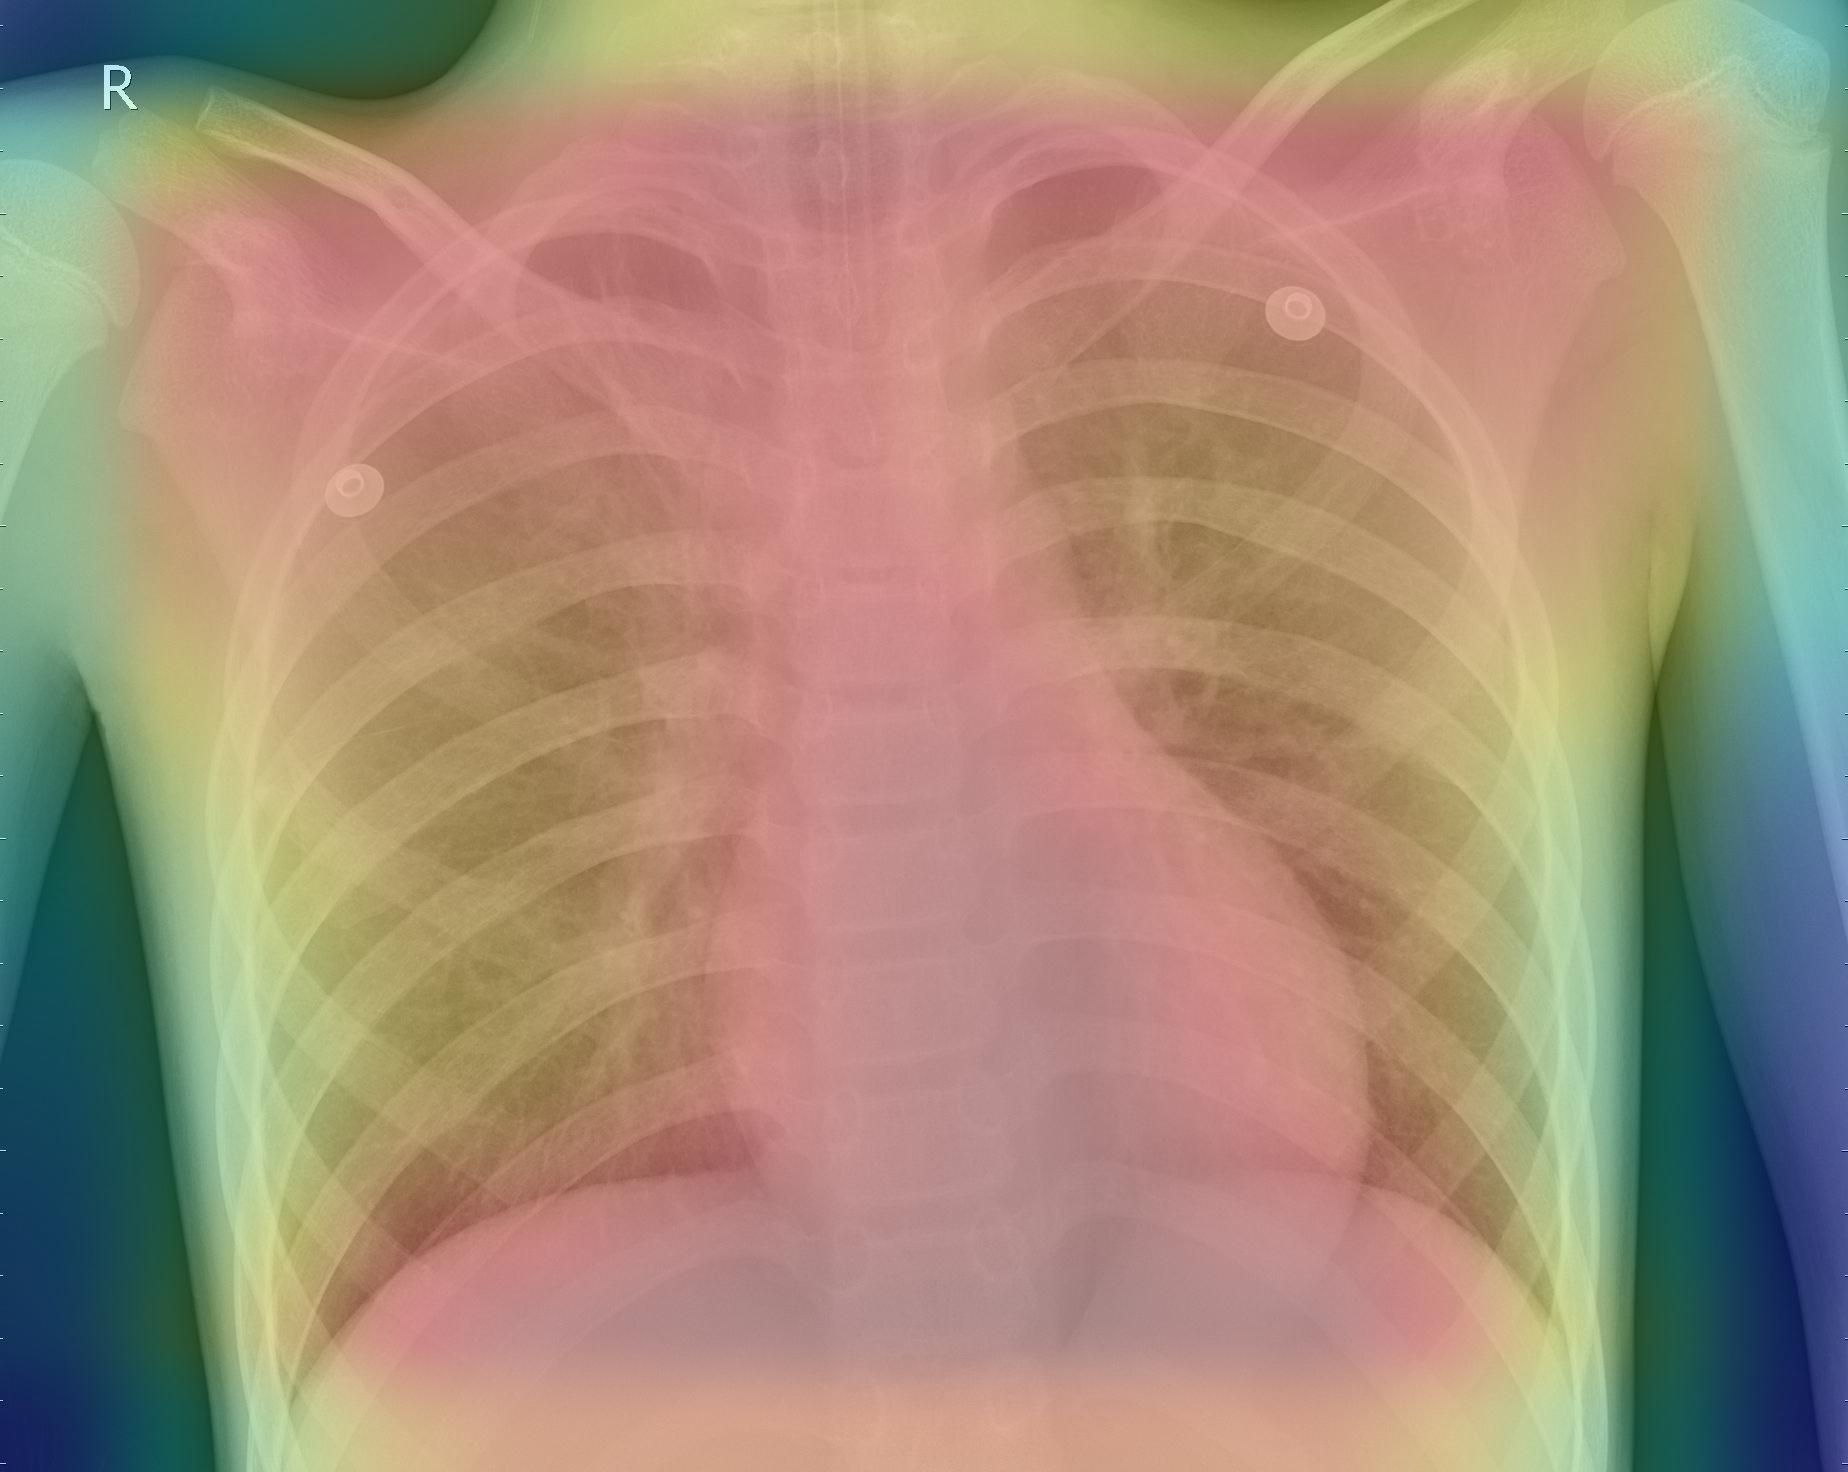

In [89]:
display(Image('grad_cam_result.jpg'))